In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from Model_less_weird import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [2]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100

In [3]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(
    N_inp, N_bar, num_states,
    narrow_search_factor=0.5, wide_search_factor=1.5,
    )

In [4]:
cache_states = [20, 30, 70]

# Example Narrow/Broad Recall

Now I just cached at location: 20


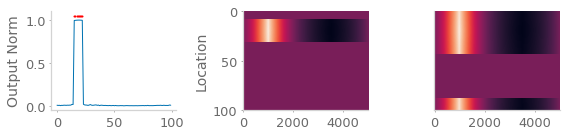

Now I just cached at location: 30


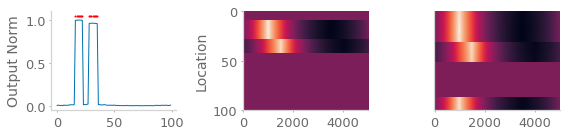

Now I just cached at location: 70


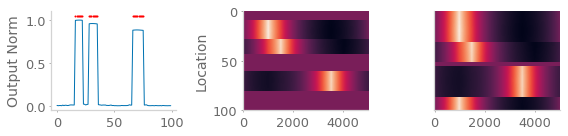

In [5]:
model.reset()

# Gaussian weights
#J_ix = 0.0002 + (0.00019995999999999952**2)*np.random.randn(model.N_bar, model.N_bar)
#J_ix = (1/np.sqrt(model.N_bar))*np.random.randn(model.N_bar, model.N_bar)

# Uniform weights
# model.J_ix = np.random.uniform(low=0.0, high=1.0, size=(model.N_bar, model.N_bar))
# model.J_ix /= np.linalg.norm(model.J_ix, axis=1)[None,:]
# model.J_ix *= 0.0002

# Random sparse weights
# J_ix = np.zeros((model.N_bar, model.N_bar))
# for i in range(model.N_bar):
#     size = 2
#     J_ix[np.random.choice(model.N_bar, size=size), i] = 1/size

#model.J_ix = J_ix

cache_identification = []
narrow_recall = []
wide_recall = []

for c_idx, cache_state in enumerate(cache_states):
    
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])

    _, _, _cache_identification, _ = model.run_recall(0., place_inputs)
    cache_identification.append(_cache_identification.copy())
    
    _, _, _narrow_recall, _ = model.run_narrow_recall(place_inputs)
    narrow_recall.append(_narrow_recall.copy())
    
    _, _, _wide_recall, _ = model.run_wide_recall(place_inputs)
    wide_recall.append(_wide_recall.copy())

    recall_plots(_cache_identification, _narrow_recall, _wide_recall, cache_states[:c_idx+1])